## Functions

In [2]:
import os 
import re
import io 
import sys
import math
import urllib
import tempfile
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path    as mpath
import matplotlib.patches as mpatches
from Bio import SeqIO
import Bio

matplotlib.rcParams["figure.max_open_warning"] = 0
matplotlib.rcParams['ps.fonttype']       = 42
matplotlib.rcParams['pdf.fonttype']      = 42
matplotlib.rcParams['font.sans-serif']   = ["Arial","Lucida Sans","DejaVu Sans","Lucida Grande","Verdana"]
matplotlib.rcParams['font.family']       = 'sans-serif'
matplotlib.rcParams['font.size']         = 10.0
matplotlib.rcParams["axes.labelcolor"]   = "#000000"
matplotlib.rcParams["axes.linewidth"]    = 1.0
matplotlib.rcParams["xtick.major.width"] = 1.0
matplotlib.rcParams["ytick.major.width"] = 1.0
matplotlib.rcParams['xtick.major.pad']   = 6
matplotlib.rcParams['ytick.major.pad']   = 6
matplotlib.rcParams['xtick.major.size']  = 6
matplotlib.rcParams['ytick.major.size']  = 6

class Garc:
    #list100 = ["#ffcdd2","#f8bbd0","#e1bee7","#d1c4e9","#c5cae9","#bbdefb","#b3e5fc","#b2ebf2","#b2dfdb","#c8e6c9","#dcedc8","#f0f4c3","#fff9c4","#ffecb3","#ffe0b2","#ffccbc","#d7ccc8","#cfd8dc",
    colorlist = ["#ff8a80","#ff80ab","#ea80fc","#b388ff","#8c9eff","#82b1ff","#84ffff","#a7ffeb","#b9f6ca","#ccff90","#f4ff81","#ffff8d","#ffe57f","#ffd180","#ff9e80","#bcaaa4","#eeeeee","#b0bec5",
                 "#ff5252","#ff4081","#e040fb","#7c4dff","#536dfe","#448aff","#18ffff","#64ffda","#69f0ae","#b2ff59","#eeff41","#ffff00","#ffd740","#ffab40","#ff6e40","#a1887f","#e0e0e0","#90a4ae"]
    _arcnum = 0
    def __setitem__(self, key, item):
        self.__dict__[key] = item

    def __getitem__(self, key):
        return self.__dict__[key] 

    def __init__(self, arc_id=None, record=None, size=1000, interspace=3, raxis_range=(500, 550), facecolor=None, edgecolor="#303030", linewidth=0.75, label=None, labelposition=0, labelsize=10, label_visible=False):
        """
        Parameters
        ----------
        arc_id : str, optional
            Unique identifier for the Garc class object. In the event an id
            value is not provided, an original unique ID is automatically 
            generated for Garc object. The default is None.
        record : Bio.SeqRecord class object or NCBI accession number, optional
            Bio.SeqRecord class object or NCBI accession number of an annotated
            sequence. If a NCBI accession number is given, the GenBank record of 
            the accession number will be loaded from NCBI public database.
            The default is None.
        size : int, optional
            Width of the arc section. If record is provided, the value is 
            instead set by the sequence length of the record. In reality
            the actual arc section width in the resultant circle is determined
            by the ratio of size to the combined sum of the size and interspace
            values of the Garc class objects in the Gcircle class object.
            The default is 1000.
        interspace : float, optional
            Distance angle (deg) to the adjacent arc section in clockwise 
            sequence. The actual interspace size in the circle is determined by
            the actual arc section width in the resultant circle is determined
            by the ratio of size to the combined sum of the size and interspace
            values of the Garc class objects in the Gcircle class object.
            The default is 3.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where line plot is drawn. The default is (500, 550).
        facecolor : str or tuple representing color code, optional
            Color for filling. The default color is set automatically. 
        edgecolor : str or tuple representing color code, optional
            Edge color of the filled area. The default is "#303030".
        linewidth : float, optional
            Edge line width. The default is 0.75.
        label : str, optional
            Label of the arc section. The default is None.
        labelposition : int, optional
            Relative label height from the center of the arc section.
            The default is 0.
        labelsize : int, optional
            Font size of the label. The default is 10.
        label_visible : bool, optional
            If True, label of the Garc object is shown on the arc section.
            The default is False.
        Raises
        ------
        ValueError
            In the event no match for the NCBI accession number value input in
            the record input variable, an error is raised.
        Returns
        -------
        None
        """
        self._parental_gcircle = None
        if arc_id == None:
            self.arc_id = str(Garc._arcnum) 
        else:
            self.arc_id = arc_id

        if record is None:
            self.record = None
            self.size = size
        
        elif type(record) == Bio.SeqRecord.SeqRecord:
            self.record = record
            self.size   = len(str(self.record.seq))
        
        elif type(record) == str:
            match = re.fullmatch("[a-zA-Z]{1,2}_?[0-9]{5,6}", record)
            if os.path.exists(record) == True:
                self.record = SeqIO.read(value, format="genbank")  
            
            if match is None:
                raise ValueError("Incorrect value for NCBI accession number.") 
            else:
                url = "https://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?tool=portal&save=file&log$=seqview&db=nuccore&report=gbwithparts&id={}&withparts=on".format(record) 
            outb = io.BytesIO()
            outs = io.StringIO()
            headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:47.0) Gecko/20100101 Firefox/47.0"} 
            request = urllib.request.Request(url, headers=headers) 
            
            with urllib.request.urlopen(request) as u:
                outb.write(u.read())
            outs.write(outb.getvalue().decode())
            
            with tempfile.TemporaryFile(mode="w+") as o:
                content = outs.getvalue()
                o.write(content)
                o.seek(0)  
                record = SeqIO.parse(o,"genbank")
                record = next(record)
            self.record = record 
            self.size = len(str(self.record.seq))
        else:
            self.record = None
            self.size = size
        
        if facecolor is None:
            facecolor = Garc.colorlist[Garc._arcnum % len(Garc.colorlist)] 
        self.interspace  = 2 * np.pi * (interspace / 360)
        self.raxis_range = raxis_range 
        self.facecolor   = facecolor 
        self.edgecolor   = edgecolor
        self.linewidth   = linewidth
        
        if label is None:
            self.label = arc_id
        else:
            self.label = label

        self.label_visible = label_visible
        self.labelposition = labelposition
        self.labelsize = labelsize
        Garc._arcnum += 1

    def calc_density(self, positions, window_size=1000):
        """
        Converts positions consisting of x-coordinates into a list of density
        values scanned in a sliding window.
        Parameters
        ----------
        positions : list of int or tuple
            List of x coordinate values or tuple consisting of two x coordinate
            values. Each coordinate value should be in the range 0 to the 
            size of Garc object.
        window_size : int, optional
            Size of the sliding window. The default is 1000.
        Raises
        ------
        ValueError
            If an inappropriate value or values is input for positions, an
            error is raised
        Returns
        -------
        densities : list
            A list consisting of density values.
        """
        densities = [] 
        positions.sort()
        for i in range(0, self.size, window_size): 
            source = tuple(range(i, i+window_size))
            amount = 0 
            for pos in positions:
                if type(pos) == int:
                    if pos in source:
                        amount += 1 
                elif type(pos) == tuple:
                    if pos[0] <= source[-1] and pos[1] >= source[0]:
                        amount += 1
                else:
                    raise ValueError("List elements should be int type or tuple consisting of two int values")
            densities.append(amount) 

        source = tuple(range(i,self.size))
        amount = 0 
        for pos in positions:
            if type(pos) == int:
                if pos in source:
                    amount += 1 
            elif type(pos) == tuple:
                if pos[0] <= source[-1] and pos[1] >= source[0]:
                    amount += 1
            else:
                raise ValueError("List elements should be int type or tuple consisting of two int values")
        densities.append(amount*((self.size-i)/window_size))     
        return densities 

    def calc_nnratio(self, n1="G", n2="C", window_size=1000, step_size=None):
        """
        Calculates the ratio of n1 and n2 base frequency for multiple windows
        along the sequence.
        Parameters
        ----------
        n1 : string corresponding to one of "ATGC", optional
            The first of the two nucleotide bases to be compared.
            The default is "G".
        n2 : string corresponding to one of "ATGC", optional
            The second of the two nucleotide bases to be compared.
            The default is "C".
        window_size : int, optional
            Size of the sliding window. The default is 1000.
        step_size : int, optional
            Size of the sliding step. The default is window_size.
        Raises
        ------
        ValueError
            In the event no record is provided, will return an error.
        Returns
        -------
        gc_amounts : np.array
            An array of the ratios computed by this method
        """
        if self.record is None:
            raise ValueError("self.record is None, please specify record value")
        
        if step_size is None:
            step_size = window_size
        
        seq = str(self.record.seq)
        gc_amounts = []
        for i in range(0, len(seq), step_size):
            if n2 is None:
                gc_amount = seq[i:i+window_size].upper().count(n1) * 1.0 / window_size
            else:
                gc_amount = (seq[i:i+window_size].upper().count(n1) + seq[i:i+window_size].upper().count(n2)) * 1.0 / window_size
            gc_amounts.append(gc_amount)
        if n2 is None:
            gc_amounts.append(seq[i:].upper().count(n1) * 1.0 / (len(seq)-i))
        else:
            gc_amounts.append((seq[i:].upper().count(n1) + seq[i:i+window_size].upper().count(n2)) * 1.0 / (len(seq)-i))
        
        self["{}{}_ratio".format(n1,n2)] = gc_amounts
        gc_amounts = np.array(gc_amounts)
        return gc_amounts

    def calc_nnskew(self, n1="G", n2="C", window_size=1000, step_size=None):
        """
        Calculates n1,n2 skew (n1-n2)/(n1+n2) for multiple windows along
        the sequence.
        Parameters
        ----------
        n1 : string corresponding to one of "ATGC", optional
            The first of the two nucleotide bases to be compared.
            The default is "G".
        n2 : string corresponding to one of "ATGC", optional
            The second of the two nucleotide bases to be compared.
            The default is "C".
        window_size : int, optional
            Size of the sliding window. The default is 1000.
        step_size : int, optional
            Size of the sliding step. The default is window_size.
        Raises
        ------
        ValueError
            In the event no record is provided, will return an error.
        Returns
        -------
        gc_skews : np.array
            An array of the skews computed by this method
        """
        #(G-C)/(G+C) 
        if self.record is None:
            raise ValueError("self.record is None, please specify record value")
        
        if step_size is None:
            step_size = window_size
        
        seq = str(self.record.seq) 
        gc_skews = []
        for i in range(0, len(seq), step_size):
            gc_skew = (seq[i:i+window_size].upper().count(n1) - seq[i:i+window_size].upper().count(n2)) * 1.0 / (seq[i:i+window_size].upper().count(n1) + seq[i:i+window_size].upper().count(n2)) * 1.0
            gc_skews.append(gc_skew)
        
        gc_skews.append((seq[i:].upper().count(n1) - seq[i:].upper().count(n2)) * 1.0 / (seq[i:].upper().count(n1) + seq[i:].upper().count(n2)) * 1.0)
        self["{}{}_skew".format(n1,n2)] = gc_skews
        gc_skews = np.array(gc_skews)
        return gc_skews 
    
class Gcircle:
    """
    A Gcircle class object provides a circle whose diameter is 1000 (a.u.) as a 
    drawing space. Any graph (line plot, scatter plot, barplot, heatmap, and chordplot) 
    can be placed on the space by specifying the raxis_range (from 0 to 1000) and 
    the corresponding Garc class object.
    """
    colors = ["#f44336","#e91e63","#9c27b0","#673ab7","#3f51b5","#2196f3","#00bcd4","#009688","#4caf50","#8bc34a","#cddc39","#ffeb3b","#ffc107","#ff9800","#ff5722","#795548","#9e9e9e","#607d8b"]
    #colors = ["#4E79A7","#F2BE2B","#E15759","#76B7B2","#59A14F","#EDC948","#B07AA1","#FF9DA7","#9C755F","#BAB0AC"]
    cmaps  = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greens, plt.cm.Greys]  
    
    def __getattr__(self, name):
        if name == "garc_dict":
            return self._garc_dict
    
    def __init__(self,  fig=None, figsize=None):
        """
        Parameters
        ----------
        fig : matplotlib.pyplot.figure object, optional
            Matplotlib Figure class object
        figsize : tuple, optional
            Figure size for the circular map
        """
        self._garc_dict = {} 
        if fig is None:
            if figsize is None:
                figsize = (8,8) 
            self.figure = plt.figure(figsize=figsize)
            self.fig_is_ext = False
        else:
            if figsize is None:
                figsize = (6,6) 
            self.figure = fig
            self.fig_is_ext = True
        self.figsize = figsize
        self.color_cycle = 0 

    def add_garc(self, garc):
        """
        Add a new Garc class object into garc_dict.
        Parameters
        ----------
        garc : Garc class object
            Garc class object to be added.
        Returns
        -------
        None
        """
        self._garc_dict[garc.arc_id] = garc

    def set_garcs(self, start=0, end=360):
        """
        Visualize the arc rectangles of the Garc class objects in .garc_dict on
        the drawing space. After the execution of this method, a new Garc class
        object cannot be added to garc_dict and figure parameter representing
        maplotlib.pyplot.figure object will be created in Gcircle object.
        Parameters
        ----------
        start : int, optional
            Start angle of the circos plot. The value range is -360 ~ 360.
            The default is 0.
        end : int, optional
            End angle of the circos plot. The value range is -360 ~ 360.
            The default is 360.
        Returns
        -------
        None
        """
        sum_length       = sum(list(map(lambda x:  self._garc_dict[x]["size"], list(self._garc_dict.keys()))))
        sum_interspace   = sum(list(map(lambda x:  self._garc_dict[x]["interspace"], list(self._garc_dict.keys()))))
        start = 2 * np.pi * start / 360
        end   = (2 * np.pi * end / 360) - sum_interspace

        s = 0
        sum_interspace = 0 
        for key in self._garc_dict.keys():
            size = self._garc_dict[key].size
            self._garc_dict[key].coordinates    = [None, None]
            self._garc_dict[key].coordinates[0] = sum_interspace + start + ((end-start) * s/sum_length) #self.theta_list[s:s+self._garc_dict[key]["size"]+1]
            self._garc_dict[key].coordinates[1] = sum_interspace + start + ((end-start) * (s+size)/sum_length)
            s = s + size
            sum_interspace += self._garc_dict[key].interspace
        
        #self.figure = plt.figure(figsize=self.figsize)
        if self.fig_is_ext:
            self.ax = self.figure.add_axes([0, 0, self.figsize[0], self.figsize[1]], polar=True)
        else:
            self.ax = self.figure.add_axes([0, 0, 1, 1], polar=True)
        self.ax.set_theta_zero_location("N")
        self.ax.set_theta_direction(-1)
        self.ax.set_ylim(0,1000)
        self.ax.spines['polar'].set_visible(False)
        self.ax.xaxis.set_ticks([])
        self.ax.xaxis.set_ticklabels([])
        self.ax.yaxis.set_ticks([])
        self.ax.yaxis.set_ticklabels([])  
                
        for i, key in enumerate(self._garc_dict.keys()):
            pos       = self._garc_dict[key].coordinates[0] 
            width     = self._garc_dict[key].coordinates[-1] - self._garc_dict[key].coordinates[0]
            height    = abs(self._garc_dict[key].raxis_range[1] - self._garc_dict[key].raxis_range[0])
            bottom    = self._garc_dict[key].raxis_range[0]
            facecolor = self._garc_dict[key].facecolor
            edgecolor = self._garc_dict[key].edgecolor
            linewidth = self._garc_dict[key].linewidth
            #print(key, pos, pos+width) 
            self.ax.bar([pos], [height], bottom=bottom, width=width, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, align="edge")
            if self._garc_dict[key].label_visible == True:
                rot = (self._garc_dict[key].coordinates[0] + self._garc_dict[key].coordinates[1]) / 2
                rot = rot*360/(2*np.pi)
                if 90 < rot < 270:
                    rot = 180-rot
                else:
                    rot = -1 * rot 
                height = bottom + height/2 + self._garc_dict[key].labelposition
                self.ax.text(pos + width/2, height, self._garc_dict[key].label, rotation=rot, ha="center", va="center", fontsize=self._garc_dict[key].labelsize)
    
    def setspine(self, garc_id, raxis_range=(550, 600), facecolor="#30303000", edgecolor="#303030", linewidth=0.75):
        """
        Set spines in the sector corresponding to the arc of 
        the Garc class object specified by garc_id.
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict.
        raxis_range : tuple (top=int, bottom=int)
            Radial axis range where line plot is drawn. The default is (550, 600).
        facecolor : str or tuple representing color code, optional
            Color for spines area. The default is "#30303000".
        edgecolor : str or tuple representing color code, optional
            Edge color of the spines boundary area. The default is "#303030".
        linewidth : float, optional
            Edge line width of spines boundary area. The default is 0.75.
        
        Returns
        -------
        None
        """
        pos     = self._garc_dict[garc_id].coordinates[0] 
        width   = self._garc_dict[garc_id].coordinates[-1] - self._garc_dict[garc_id].coordinates[0]
        height  = abs(raxis_range[1] - raxis_range[0])
        bottom  = raxis_range[0]
        self.ax.bar([pos], [height], bottom=bottom, width=width, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, align="edge", zorder=0)
    
    def lineplot(self, garc_id, data, positions=None, raxis_range=(550, 600), rlim=None, linestyle="solid", linecolor=None, linewidth=1.0, spine=False):
        """
        Plot a line in the sector corresponding to the arc of the Garc class
        object specified by garc_id.
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict.
        data : list or numpy.ndarray
            Numerical data to used for plot generation.
        positions : list or numpy.ndarray 
            The x coordinates of the values in data on the Garc class object 
            when the plot is drawn on the rectangular coordinates. Each
            coordinate value should be in the range 0 to size of the Garc class
            object specified by garc_id. By the method execution, the 
            coordinates are converted to proper angle coordinates. If positions
            are not given, proper coordinates values are generated according to
            the length of data. The default is None.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where line plot is drawn.
            The default is (550, 600).
        rlim : tuple (top=int, bottom=int)
            The top and bottom r limits in data coordinates. If rlim value is
            not given, the maximum value and the minimum value in data will be 
            set to top and bottom, respectively. The default is None.
        linestyle : str, optional
            Line style. The default is "solid".
            Possible line styles are documented at
            https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
            
        linecolor : str or tuple representing color code, optional
            Color of the line plot. If linecolor value is not given, the color 
            will be set according to the default color set of matplotlib. To 
            specify the opacity for a line color, please use `(r,g,b,a)` or 
            `#XXXXXXXX` format. The default is None.
        linewidth : float, optional
            Edge line width. The default is 1.0.
        spine : bool, optional
            If True, spines of the Garc object is shown on the arc section.
            The default is False.
        Returns
        -------
        None
        """
        start = self._garc_dict[garc_id].coordinates[0] 
        end   = self._garc_dict[garc_id].coordinates[-1]
        size  = self._garc_dict[garc_id].size - 1
        positions_all = np.linspace(start, end, len(data), endpoint=True)
        if positions is None:
            positions = positions_all
        else:
            new_positions = [] 
            for p in positions:
                new_positions.append(start + ((end-start) * p/size))
            positions = new_positions
        
        if raxis_range is None:
            raxis_range = raxis_range[0]   
        bottom = raxis_range[0]
        top    = raxis_range[1] 

        if linecolor is None:
            linecolor = Gcircle.colors[self.color_cycle % len(Gcircle.colors)] 
            self.color_cycle += 1
        
        if rlim is None:
            rlim = (min(data) - 0.05 * abs(min(data)), max(data) + 0.05 * abs(max(data))) 

        min_value     = rlim[0]
        max_value     = rlim[1] 
        new_data      = [] 
        new_positions = [] 
        new_data_array      = [] 
        new_positions_array = [] 
        for p, v in zip(positions, data):
            if v > rlim[1] or v < rlim[0]: 
                new_data_array.append(new_data)
                new_positions_array.append(new_positions) 
                new_data      = [] 
                new_positions = [] 
            else: 
                new_data.append(v) 
                new_positions.append(p) 
        new_data_array.append(new_data)
        new_positions_array.append(new_positions) 
        for data, positions in zip(new_data_array, new_positions_array): 
            if len(positions) > 0: 
                data = np.array(data) - min_value
                data = bottom + np.array(data * ((top - bottom) / (max_value - min_value)))
                self.ax.plot(positions, data, color=linecolor, linewidth=linewidth, linestyle=linestyle)
        
        if spine == True:
            self.setspine(garc_id, raxis_range)

    def fillplot(self, garc_id, data, positions=None, raxis_range=(550, 600), rlim=None, base_value=None, facecolor=None, edgecolor="#303030", linewidth=0.0, spine=False):  
        """
        Fill a specified area in the sector corresponding to the arc of the 
        Garc class object specified by garc_id.
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict.
        data : list or numpy.ndarray
            Numerical data to used for plot generation.
        positions : list or numpy.ndarray 
            The x coordinates of the values in data on the Garc class object 
            when the plot is drawn on the rectangular coordinates. Each
            coordinate value should be in the range 0 to size of the Garc class
            object specified by garc_id. By the method execution, the
            coordinates are converted to proper angle coordinates. If positions
            are not given, proper coordinates values are generated according to
            the length of data. The default is None.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where line plot is drawn. The default is (550, 600).
        rlim : tuple (top=int, bottom=int)
            The top and bottom r limits in data coordinates. If rlim value is
            not given, the maximum value and the minimum value in data will be 
            set to top and bottom, respectively. 
            The default is `(min(data), max(data))`.
        base_value : float, optional
            Base line height in data coordinates. The area between the base 
            line and the data line is filled by facecolor. The default is None.
        facecolor : str or tuple representing color code, optional
            Color for filling. The default is None.
        edgecolor : str or tuple representing color code, optional
            Edge color of the filled area. The default is "#303030".
        linewidth : float, optional
            Edge line width. The default is 0.0.
        spine : bool, optional
            If True, spines of the Garc object is shown on the arc section.
            The default is False.
        Returns
        -------
        None.
        """
        start = self._garc_dict[garc_id].coordinates[0] 
        end   = self._garc_dict[garc_id].coordinates[-1]
        size  = self._garc_dict[garc_id].size - 1
        positions_all = np.linspace(start, end, len(data), endpoint=True)
        if positions is None:
            positions = positions_all
        else:
            new_positions = [] 
            for p in positions:
                new_positions.append(start + ((end-start) * p/size))
            positions = new_positions

        if raxis_range is None:
            raxis_range = raxis_range[0]   
        bottom = raxis_range[0]
        top    = raxis_range[1] 

        if facecolor is None:
            facecolor = Gcircle.colors[self.color_cycle % len(Gcircle.colors)] 
            self.color_cycle += 1
        
        if rlim is None:
            rlim = (min(data) - 0.05 * abs(min(data)), max(data) + 0.05 * abs(max(data))) 
        
        min_value     = rlim[0]
        max_value     = rlim[1] 
        if base_value is None:
            base_value = min_value
        new_data      = [] 
        new_positions = [] 
        new_data_array      = [] 
        new_positions_array = [] 
        for p, v in zip(positions, data):
            if v > rlim[1] or v < rlim[0]: 
                new_data_array.append(new_data)
                new_positions_array.append(new_positions) 
                new_data = [] 
                new_positions = [] 
            else: 
                new_data.append(v) 
                new_positions.append(p) 
        new_data_array.append(new_data)
        new_positions_array.append(new_positions) 
        for data, positions in zip(new_data_array, new_positions_array): 
            if len(positions) > 0:  
                base_value = base_value - min_value
                base_value = bottom + base_value * ((top - bottom) / (max_value - min_value)) 
                data = np.array(data) - min_value
                data = bottom + np.array(data * ((top - bottom) / (max_value - min_value)))
                self.ax.fill_between(positions, data, base_value, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor)
        
        if spine == True:
            self.setspine(garc_id, raxis_range)

    def scatterplot(self, garc_id, data, positions=None, raxis_range=(550, 600), rlim=None, markershape="o", markersize=5, facecolor=None, edgecolor="#303030", linewidth=0.0, spine=False):
        """
        Plot markers in the sector corresponding to the arc of the Garc class
        object specified by garc_id.
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict.
        data : list or numpy.ndarray
            Numerical data to used for plot generation.
        positions : list or numpy.ndarray 
            The x coordinates of the values in data on the Garc class object 
            when the plot is drawn on the rectangular coordinates. Each
            coordinate value should be in the range 0 to size of the Garc class
            object specified by garc_id. By the method execution, the
            coordinates are converted to proper angle coordinates. If positions
            are not given, proper coordinates values are generated according to
            the length of data. The default is None.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where line plot is drawn. The default is (550, 600).
        rlim : tuple (top=int, bottom=int)
            The top and bottom r limits in data coordinates. If rlim value is
            not given, the maximum value and the minimum value in data will be 
            set to top and bottom, respectively. 
            The default is `(min(data), max(data))`.
        markershape : str, optional
            Marker shape. The default is "o".
            Possible marker are listed at
            https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html
        markersize : float or list of float, optional
            Size(s) of the marker(s). The default is 5.
        facecolor : str or tuple representing color code or list thereof, optional
            Face color(s) of the markers. If value type is list, the length of
            facecolor should be the same as the data length.
            The default is None.
        edgecolor : str or tuple representing color code, optional
            Edge color of the markers. The default is "#303030".
        linewidth : float, optional
            Edge line width of the markers. The default is 0.0.
        spine : bool, optional
            If True, spines of the Garc object is shown on the arc section.
            The default is False.
        Returns
        -------
        None
        """
        start = self._garc_dict[garc_id].coordinates[0] 
        end   = self._garc_dict[garc_id].coordinates[-1]
        size  = self._garc_dict[garc_id].size - 1
        positions_all = np.linspace(start, end, len(data), endpoint=True)
        if positions is None:
            positions = positions_all
        else:
            new_positions = [] 
            for p in positions:
                new_positions.append(start + ((end-start) * p/size))
            positions = new_positions
        
        if raxis_range is None:
            raxis_range = raxis_range[0]   
        bottom = raxis_range[0]
        top    = raxis_range[1] 

        if facecolor is None:
            facecolor = Gcircle.colors[self.color_cycle % len(Gcircle.colors)] 
            self.color_cycle += 1
        
        if rlim is None:
            rlim = (min(data) - 0.05 * abs(min(data)), max(data) + 0.05 * abs(max(data))) 

        min_value     = rlim[0]
        max_value     = rlim[1] 
        new_data      = [] 
        new_positions = [] 
        new_data_array      = [] 
        new_positions_array = [] 
        for p, v in zip(positions, data):
            if v > rlim[1] or v < rlim[0]: 
                new_data_array.append(new_data)
                new_positions_array.append(new_positions)
                new_data      = [] 
                new_positions = [] 
            else: 
                new_data.append(v) 
                new_positions.append(p) 
        
        new_data_array.append(new_data)
        new_positions_array.append(new_positions) 
        for positions, data in zip(new_positions_array, new_data_array): 
            if len(positions) > 0:
                data = np.array(data) - min_value
                data = bottom + np.array(data * ((top - bottom) / (max_value - min_value)))
                self.ax.scatter(positions, data, c=facecolor, s=markersize, linewidth=linewidth, edgecolor=edgecolor, marker=markershape)

        if spine == True:
            self.setspine(garc_id, raxis_range)
    
    def barplot(self, garc_id, data, positions=None, width=None, raxis_range=(550, 600), rlim=None, base_value=None, facecolor=None, edgecolor="#303030", linewidth=0.0, spine=False):  
        """
        Plot bars in the sector corresponding to the arc of the Garc class 
        object specified by garc_id.
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict.
        data : list or numpy.ndarray
            Numerical data to used for plot generation.
        positions : list or numpy.ndarray 
            The x coordinates of the values in data on the Garc class object 
            when the plot is drawn on the rectangular coordinates. Each
            coordinate value should be in the range 0 to size of the Garc class
            object specified by garc_id. By the method execution, the
            coordinates are converted to proper angle coordinates. If positions
            are not given, proper coordinates values are generated according to
            the length of data. The default is None.
        width : float or list of float
            Width(s) of the bars. The default is `garc_object.size / len(data)`.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where line plot is drawn. The default is (550, 600).
        rlim : tuple (top=int, bottom=int)
            The top and bottom r limits in data coordinates. If rlim value is
            not given, the maximum value and the minimum value in data will be 
            set to top and bottom, respectively. 
            The default is (min(data), max(data).
        base_value : float, optional
            Base line height in data coordinates. The area between the base 
            line and the data line is filled by facecolor. The default is None.
        facecolor : str or tuple representing color code or list thereof, optional
            Facecolor(s) of the bars. If value type is list, the length of 
            facecolor should be the same as the data length.
            The default is None.
        edgecolor : str or tuple representing color code, optional
            Edge color of the bars. The default is "#303030".
        linewidth : float, optional
            Edge line width of the bars. The default is 0.0.
        spine : bool, optional
            If True, spines of the Garc object is shown on the arc section.
            The default is False.
        Returns
        -------
        None
        """
        start = self._garc_dict[garc_id].coordinates[0] 
        end   = self._garc_dict[garc_id].coordinates[-1]
        size  = self._garc_dict[garc_id].size 
        positions_all = np.linspace(start, end, len(data), endpoint=False)
        if positions is None:
            positions = positions_all
        else:
            new_positions = [] 
            for p in positions:
                new_positions.append(start + ((end-start) * p/size))
            positions = new_positions
        
        if width is None:
            width = [positions[1] - positions[0]] * len(data) 
        elif type(width) == float or type(width) == int:
            width = [(end-start) * width/size] * len(data)  
        else:
            new_width = [] 
            for w in width:
                new_w = (end-start) * w/size
                new_width.append(new_w) 
            width = new_width 

        if raxis_range is None:
            raxis_range = raxis_range[0]   
        bottom = raxis_range[0]
        top    = raxis_range[1] 

        if facecolor is None:
            facecolor = Gcircle.colors[self.color_cycle % len(Gcircle.colors)] 
            self.color_cycle += 1
        
        if rlim is None:
            if min(data) != max(data):
                rlim = (min(data) - 0.05 * abs(min(data)), max(data) + 0.05 * abs(max(data))) 
            else:
                rlim = (min(data), max(data))
        
        min_value     = rlim[0] if rlim[0] is not None else min(data)
        max_value     = rlim[1] if rlim[1] is not None else max(data)
        if base_value is None:
            base_value = min_value

        new_data            = [] 
        new_positions       = [] 
        new_width           = [] 
        new_data_array      = [] 
        new_positions_array = [] 
        new_width_array     = [] 
        for p, v, w in zip(positions, data, width):
            if v > rlim[1] or v < rlim[0]: 
                new_data_array.append(new_data)
                new_positions_array.append(new_positions)
                new_width_array.append(new_width)
                new_data      = [] 
                new_width     = [] 
                new_positions = [] 
            else: 
                new_data.append(v) 
                new_positions.append(p)
                new_width.append(w) 
        
        new_data_array.append(new_data)
        new_positions_array.append(new_positions) 
        new_width_array.append(new_width)
        for data, positions, width in zip(new_data_array, new_positions_array, new_width_array): 
            if len(positions) > 0: 
                base_value = base_value - min_value
                if min_value != max_value:
                    base_value = bottom + base_value * ((top - bottom) / (max_value - min_value)) 
                else:
                    base_value = raxis_range[0] 
                
                data = np.array(data) - min_value
                if min_value != max_value:
                    data = np.array(data) * ((top - bottom) / (max_value - min_value))
                    data = np.array(data) - (base_value - raxis_range[0])
                else:
                    data = [raxis_range[1]-raxis_range[0]] * len(data) 
                self.ax.bar(positions, data, width=width, bottom=base_value, color=facecolor, linewidth=linewidth, edgecolor=edgecolor, align="edge") 
    
        if spine == True:
            self.setspine(garc_id, raxis_range)
    
    def heatmap(self, garc_id, data, positions=None, width=None, raxis_range=(550, 600), cmap=None, vmin=None, vmax=None, edgecolor="#303030", linewidth=0.0, spine=False):  
        """
        Visualize magnitudes of data values by color scale in the sector
        corresponding to the arc of the Garc class object specified by garc_id.
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict.
        data : list or numpy.ndarray
            Numerical data to used for plot generation.
        positions : list or numpy.ndarray 
            The x coordinates of the values in data on the Garc class object 
            when the plot is drawn on the rectangular coordinates. Each
            coordinate value should be in the range 0 to size of the Garc class
            object specified by garc_id. By the method execution, the
            coordinates are converted to proper angle coordinates. If positions
            are not given, proper coordinates values are generated according to
            the length of data. The default is None.
        width : float or list of float, optional
            Width(s) of the bars. The default is `garc_object.size / len(data)`.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where heatmap is drawn. The default is (550, 600).
        cmap : str representing matplotlib colormap name or
            matplotlib.colors.Colormap object, optional
            The mapping from data values to color space. The default is 'Reds'.
        vmin : float, optional
            Minimum data threshold for color scale. The default is min(data).
        vmax : TYPE, optional
            Maximum data threshold for color scale. The default is max(data).
        edgecolor : str or tuple representing color code, optional
            Edge color of the bars. The default is "#303030".
        linewidth : float, optional
            Edge line width of the bars. The default is 0.0.
        spine : bool, optional
            If True, spines of the Garc object is shown on the arc section.
            The default is False.
        Returns
        -------
        None
        """
        start = self._garc_dict[garc_id].coordinates[0] 
        end   = self._garc_dict[garc_id].coordinates[-1]
        size  = self._garc_dict[garc_id].size 
        positions_all = np.linspace(start, end, len(data), endpoint=False)
        if positions is None:
            positions = positions_all
        else:
            new_positions = [] 
            for p in positions:
                new_positions.append(start + ((end-start) * p/size))
            positions = new_positions
        
        if width is None:
            width = [positions[1] - positions[0]] * len(data) 
        elif type(width) == float or type(width) == int:
            width = [(end-start) * width/size] * len(data)  
        else:
            new_width = [] 
            for w in width:
                new_w = (end-start) * w/size
                new_width.append(new_w) 
            width = new_width 

        if raxis_range is None:
            raxis_range = raxis_range[0]   
        bottom = raxis_range[0]
        top    = raxis_range[1] 
        height = top - bottom

        if cmap is None:
            cmap = Gcircle.cmaps[self.cmap_cycle % len(Gcircle.cmaps)] 
            self.cmap_cycle += 1

        if vmax is None:
            max_value = max(data)
        else:
            max_value = vmax
        
        if vmin is None:
            min_value = min(data) 
        else:
            min_value = vmin
        
        facecolors = [] 
        for d in data:
            facecolors.append(cmap(d/(max_value-min_value)))
        self.ax.bar(positions, height=[height] * len(positions), width=width, bottom=bottom, color=facecolors, edgecolor=edgecolor, linewidth=linewidth, align="edge")  

        if spine == True:
            self.setspine(garc_id, raxis_range)
    
    def featureplot(self, garc_id, feature_type=None, source=None, raxis_range=(550, 600), facecolor=None, edgecolor="#303030", linewidth=0.0, spine=False):  
        """
        Visualize sequence features with bar plots in the sector corresponding
        to the arc of the Garc class object specified by garc_id.
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict.
        feature_type : str, optional
            Biological nature of the Bio.Seqfeature class objects (Any value is
            acceptable, but GenBank format requires registering a biological 
            nature category for each sequence feature). If the value is "all",
            all features in source will be drawn in the sector of the Garc 
            class object specified by grac_id. The default is 'all'.
        source : list of Bio.SeqFeature object, optional
            List of Bio.Seqfeature class object. If source value is not given, 
            record.features of the Garc class object specified by grac_id is 
            used. The default is record.features of the Garc class object
            specified by grac_id.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where feature plot is drawn. The default is (550, 600).
        facecolor : str or tuple representing color code or list thereof, optional
            Facecolor(s) of the bars. If value type is list, the length of 
            facecolor should be the same as the data length.
            The default is None.
        edgecolor : str or tuple representing color code, optional
            Edge color of the bars. The default is "#303030".
        linewidth : float, optional
            Edge line width of the bars. The default is 0.0.
        spine : bool, optional
            If True, spines of the Garc object is shown on the arc section.
            The default is False.
        Returns
        -------
        None
        """
        start = self._garc_dict[garc_id].coordinates[0] 
        end   = self._garc_dict[garc_id].coordinates[-1] 
        size  = self._garc_dict[garc_id].size - 1

        if source is None:
            source = self.record.features

        if feature_type is None:
            feature_list = source
        else:
            feature_list = [feat for feat in source if feat.type == feature_type]
        
        positions = [] 
        widths = [] 
        for feat in feature_list:
            if feat.location.strand >= 0:
                s = int(feat.location.parts[0].start.position) 
                e = int(feat.location.parts[-1].end.position)
                pos   = start + ((end-start) * s/size)
                width = start + ((end-start) * e/size) - pos    
                positions.append(pos) 
                widths.append(width)
            else:
                s = int(feat.location.parts[-1].start.position) 
                e = int(feat.location.parts[0].end.position)
                pos   = start + ((end-start) * s/size)
                width = start + ((end-start) * e/size) - pos    
                positions.append(pos) 
                widths.append(width)

        bottom = raxis_range[0]
        top    = raxis_range[1] 
        
        if facecolor is None:
            facecolor = Gcircle.colors[self.color_cycle % len(Gcircle.colors)] 
            self.color_cycle += 1
        self.ax.bar(positions, [abs(top-bottom)] * len(positions) , width=widths, bottom=bottom, color=facecolor, edgecolor=edgecolor, linewidth=linewidth, align="edge")
        if spine == True:
            self.setspine(garc_id, raxis_range)
    
    def chord_plot(self, start_list, end_list, facecolor=None, edgecolor=None, linewidth=0.0):
        """
        Visualize interrelationships between data.
        Parameters
        ----------
        start_list : tuple
            Start data location of linked data.  
            The tuple is composed of four parameters:
            - `arc_id` : `str`  
                The ID of the first Garc class object to be compared.
                The ID should be in Gcircle object.garc_dict.
            - `edge_position1` : `int`  
                The minimal x coordinates on the Garc class object 
                when the plot is drawn on the rectangular coordinates.
            - `edge_position2` : `int`  
                The maximal x coordinates on the Garc class object 
                when the plot is drawn on the rectangular coordinates.
            - `raxis_position` : `int`  
                The base height for the drawing chord.
        end_list : tuple
            End data location of linked data.  
            The tuple is composed of four parameters:
            - `arc_id` : `str`  
                The ID of the second Garc class object to be compared.
                The ID should be in Gcircle object.garc_dict. 
            - `edge_position1` : `int`  
                The minimal x coordinates on the Garc class object 
                when the plot is drawn on the rectangular coordinates.
            - `edge_position2` : `int`  
                The maximal x coordinates on the Garc class object 
                when the plot is drawn on the rectangular coordinates.
            - `raxis_position` : `int`  
                The base height for the drawing chord.
        facecolor : str or tuple representing color code, optional
            Facecolor of the link. The default is None.
        edgecolor : str or tuple representing color code, optional
            Edge color of the link. The default is "#303030".
        linewidth : float, optional
            Edge line width of the link. The default is 0.0.
        Returns
        -------
        None
        """
        garc_id1 = start_list[0]
        garc_id2 = end_list[0]
        center = 0 

        start1 = self._garc_dict[garc_id1].coordinates[0] 
        end1   = self._garc_dict[garc_id1].coordinates[-1] 
        size1  = self._garc_dict[garc_id1].size - 1
        sstart = start1 + ((end1-start1) * start_list[1]/size1) 
        send   = start1 + ((end1-start1) * start_list[2]/size1)
        stop   = start_list[3] 
        
        start2 = self._garc_dict[garc_id2].coordinates[0] 
        end2   = self._garc_dict[garc_id2].coordinates[-1] 
        size2  = self._garc_dict[garc_id2].size - 1
        ostart = start2 + ((end2-start2) * end_list[1]/size2) 
        oend   = start2 + ((end2-start2) * end_list[2]/size2)
        etop   = end_list[3] 

        if facecolor is None:
            facecolor = Gcircle.colors[self.color_cycle % len(Gcircle.colors)] + "80" 
            self.color_cycle += 1
        
        z1 = stop - stop * math.cos(abs((send-sstart) * 0.5)) 
        z2 = etop - etop * math.cos(abs((oend-ostart) * 0.5)) 
        if sstart == ostart: 
            pass 
        else:
            Path      = mpath.Path
            path_data = [(Path.MOVETO,  (sstart, stop)),
                         (Path.CURVE3,  (sstart, center)),     
                         (Path.CURVE3,  (oend,   etop)),
                         (Path.CURVE3,  ((ostart+oend)*0.5, etop+z2)),
                         (Path.CURVE3,  (ostart, etop)),
                         (Path.CURVE3,  (ostart, center)),
                         (Path.CURVE3,  (send,   stop)),
                         (Path.CURVE3,  ((sstart+send)*0.5, stop+z1)),
                         (Path.CURVE3,  (sstart, stop)),
                        ]
            codes, verts = list(zip(*path_data)) 
            path  = mpath.Path(verts, codes)
            patch = mpatches.PathPatch(path, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, zorder=0)
            self.ax.add_patch(patch)

    def tickplot(self, garc_id, raxis_range=None, tickinterval=1000, tickpositions=None, ticklabels=None, tickwidth=1, tickcolor="#303030", ticklabelsize=10, ticklabelcolor="#303030", ticklabelmargin=10, tickdirection="outer", ticklabelorientation="vertical"):
        """
        Plot ticks on the arc of the Garc class object
        
        Parameters
        ----------
        garc_id : str 
            ID of the Garc class object. The ID should be in Gcircle object.garc_dict. 
        raxis_range : tuple (top=int, bottom=int)
            Radial axis range where tick plot is drawn.  
            If direction is "inner", the default is `(r0 - 0.5 * abs(r1 -r0), r0)`.  
            If direction is "outer", the default is `(r1, r1 + 0.5 * abs(r1 -r0))`.  
            `r0, r1 = Garc_object.raxis_range[0], Garc_object.raxis_range[1]`
        tickinterval : int
            Tick interval.
            The default is 1000. If `tickpositions` value is given, this value will be ignored.
        tickpositions : list of int 
            Positions on the arc of the Garc class object. 
            If you set ticks on your specified positions, please use this parameter instead of tickinterval
            The values should be less than `Garc_object.size`.
        ticklabels : list of int or list or str
            Labels for ticks on the arc of the Garc class object.
            The default is same with tickpositions.
        tickwidth : float
            Tick width. The default is 1.0.
        tickcolor : str or float representing color code
            Tick color. The default is "#303030"
        ticklabelsize : float
            Tick label fontsize. The default is 10.
        ticklabelcolor : str
            Tick label color, The default is "#303030".
        ticklabelmargin : float
            Tick label margin. The default is 10.
        tickdirection : str ("outer" or "inner")
            Tick direction. The default is "outer".
        ticklabelorientation : str ("vertical" or "horizontal")
            Tick label orientation. The default is "vertical".
        
        Returns
        -------
        None
        """
        start = self._garc_dict[garc_id].coordinates[0] 
        end   = self._garc_dict[garc_id].coordinates[-1]
        size  = self._garc_dict[garc_id].size + 1
        positions_all = np.linspace(start, end, size, endpoint=True)
        
        if raxis_range is None:
            r0, r1 = self._garc_dict[garc_id].raxis_range
            tickheight = 0.5 * abs(r1 - r0)
            if tickdirection == "outer":
                raxis_range = (r1, r1 + tickheight)
            elif tickdirection == "inner":
                raxis_range = (r0 - tickheight, r0)

        if tickpositions is None:
            tickpositions = [pos for pos in range(0, size, tickinterval)]

        if ticklabels is None:
            ticklabels = [None] * len(tickpositions) 
        
        elif ticklabels == "None":
            ticklabels = tickpositions 
        
        for pos, label in zip(tickpositions, ticklabels):
            self.ax.plot([positions_all[pos], positions_all[pos]], raxis_range, linewidth=tickwidth, color=tickcolor)
            if label is None:
                pass 
            else:
                ticklabel_rot = self._get_label_rotation(start + ((end - start) * (pos / size)), ticklabelorientation)
                if ticklabelorientation == "horizontal":
                    label_width = ticklabelsize * 2
                elif ticklabelorientation == "vertical":
                    label_width = ticklabelsize * len(str(label))

                if tickdirection == "outer":
                    y_pos = raxis_range[1] + (label_width + ticklabelmargin)
                elif tickdirection == "inner":
                    y_pos = raxis_range[0] - (label_width + ticklabelmargin)

                self.ax.text(positions_all[pos], y_pos, str(label), rotation=ticklabel_rot, ha="center", va="center", fontsize=ticklabelsize, color=ticklabelcolor)
    
    def _get_label_rotation(self, position, orientation="horizontal"):
        """
        Get label rotation from label radian position 
        
        Parameters
        ----------
        position : float 
            Label radian position (-2 * np.pi <= position <= 2 * np.pi)
        orientation : str ("vertical" or "horizontal")
            Label orientation, The default is "horizontal"
        
        Returns
        -------
        rotation : float
            Label rotation
        """
        position_degree = position * (180 / np.pi) #-360 <= position_degree <= 360
        if orientation == "horizontal":
            rotation = 0 - position_degree
            if -270 <= position_degree < -90 or 90 <= position_degree < 270:
                rotation += 180
        elif orientation == "vertical":
            rotation = 90 - position_degree
            if -180 <= position_degree < 0 or 180 <= position_degree < 360:
                rotation += 180
        return rotation

    def save(self, file_name="test", format="pdf", dpi=None):
        """
        Save image of Gcircle class figure object
        Parameters
        ----------
        file_name : str, optional
            File name of figure. The default is "test".
        format : str, optional
            File format of figure. The default is "pdf"
        dpi : int, optional
            Dpi of figure. The default is None.
        Returns
        -------
        None
        """
        self.figure.patch.set_alpha(0.0) 
        if format == "pdf" and dpi is None:
            self.figure.savefig(file_name + ".pdf", bbox_inches="tight")
        else:
            if dpi is None:
                dpi = 600
            self.figure.savefig(file_name + "." + format, bbox_inches="tight", dpi=dpi)
        return self.figure

In [3]:
import math
import numpy as np 
from Bio import Phylo

class Tarc(Garc):
    def __init__(self, arc_id=None, tree=None, format="newick", interspace=3, raxis_range=(900, 950), facecolor=None, edgecolor="#303030", linewidth=0, label=None, labelposition=0, labelsize=10, label_visible=False):
        """
        Parameters
        ----------
        arc_id : str, optional
            Unique identifier for the Garc class object. In the event an id
            value is not provided, an original unique ID is automatically 
            generated for Garc object. The default is None.
        tree : str
            File name of phylogenetic tree
        format : str 
            Format of phylogenetic tree. The default is "newick".
        interspace : float, optional
            Distance angle (deg) to the adjacent arc section in clockwise 
            sequence. The actual interspace size in the circle is determined by
            the actual arc section width in the resultant circle is determined
            by the ratio of size to the combined sum of the size and interspace
            values of the Garc class objects in the Gcircle class object.
            The default is 3.
        raxis_range : tuple (top=int, bottom=int), optional
            Radial axis range where line plot is drawn. The default is (900, 950).
        facecolor : str or tuple representing color code, optional
            Color for filling. The default is None.
        edgecolor : str or tuple representing color code, optional
            Edge color of the filled area. The default is "#303030".
        linewidth : float, optional
            Edge line width. The default is 0.
        label : str, optional
            Label of the arc section. The default is None.
        labelposition : int, optional
            Relative label height from the center of the arc section.
            The default is 0.
        labelsize : int, optional
            Font size of the label. The default is 10.
        label_visible : bool, optional
            If True, label of the Garc object is shown on the arc section.
            The default is False.
        Returns
        -------
        None
        """
        self.tree = Phylo.read(tree, format)
        self.size = len(self.tree.get_terminals()) 
        self._tree_plotted = 0  
        self._parental_gcircle = None
        if arc_id == None:
            self.arc_id = str(Garc._arcnum) 
        else:
            self.arc_id = arc_id
         
        self.interspace  = 2 * np.pi * (interspace / 360)
        self.raxis_range = raxis_range 
        self.facecolor   = facecolor 
        self.edgecolor   = edgecolor
        self.linewidth   = linewidth
        
        if label is None:
            self.label = arc_id
        else:
            self.label = label

        self.label_visible = label_visible
        self.labelposition = labelposition
        self.labelsize     = labelsize
        
        self._get_col_positions() 
        self._get_row_positions()

        Garc._arcnum += 1
            
    def _get_col_positions(self):
        taxa   = self.tree.get_terminals()
        depths = self.tree.depths()
        max_label_width = max(len(str(taxon)) for taxon in taxa)
        drawing_width   = 100 - max_label_width - 1
        if max(depths.values()) == 0:
            depths = self.tree.depths(unit_branch_lengths=True)
        fudge_margin         = math.log(len(taxa), 2)
        cols_per_branch_unit = (drawing_width - fudge_margin) / float(max(depths.values()))
        positions            = {clade: blen * cols_per_branch_unit + 1.0 for clade, blen in depths.items()}
        self._col_positions   = positions

    def _get_row_positions(self):
        taxa = self.tree.get_terminals()
        positions = {taxon: 2 * idx for idx, taxon in enumerate(taxa)}
        def calc_row(clade):
            for subclade in clade:
                if subclade not in positions:
                    calc_row(subclade)
            positions[clade] = (
                positions[clade.clades[0]] + positions[clade.clades[-1]]
            ) // 2
        calc_row(self.tree.root)
        self._row_positions = positions
       
        self.clade_dict       = {} 
        self.terminal_dict    = {} 
        self.nonterminal_dict = {} 
        keys = list(self._row_positions.keys()) 
        keys.sort(key=lambda x: self._row_positions[x]) 
        for key in keys:
            if key in taxa:
                self.terminal_dict[key.name] = key
            else:
                self.nonterminal_dict[key.name] = key
            self.clade_dict[key.name] = key

    def _convert(self, thetalim, rlim):
        col_values = list(self._col_positions.values()) 
        row_values = list(self._row_positions.values()) 
        row_min, row_max = np.min(row_values), np.max(row_values) 
        col_min, col_max = np.min(col_values), np.max(col_values)
        
        theta_positions = [thetalim[0] + (v * abs(thetalim[1]-thetalim[0])/abs(row_min-row_max)) for v in row_values]
        if rlim[0] < rlim[1]:
            r_positions = [rlim[0] + (v * abs(rlim[1]-rlim[0])/abs(col_min-col_max)) for v in col_values]
        else:
            r_positions = [rlim[0] - (v * abs(rlim[1]-rlim[0])/abs(col_min-col_max)) for v in col_values]
        self._theta_dict = dict(zip(list(self._row_positions.keys()) ,theta_positions)) 
        self._r_dict     = dict(zip(list(self._col_positions.keys()) ,r_positions))
    
    def _plot_tree(self, ax, thetalim=None, rlim=None, cladevisual_dict=None, highlight_dict=None, linewidth=None, linecolor=None):
        if linewidth is None:
            linewidth = 0.5
        
        if linecolor is None:
            linecolor = "k"
        
        if cladevisual_dict is None:
            cladevisual_dict = {} 
        
        self._tree_rlim = rlim
        if rlim[0] < rlim[1]:
            self._tree_direction = "inner"
        else:
            self._tree_direction = "outer"
        
        self._convert(thetalim, rlim)
        s   = []
        c   = []
        ecs = []
        lws = []
        for clade in self._theta_dict:
            if clade.name not in cladevisual_dict:
                cladevisual_dict[clade.name] = {}
            cladevisual_dict[clade.name].setdefault("size",0) 
            cladevisual_dict[clade.name].setdefault("color","k")
            cladevisual_dict[clade.name].setdefault("edgecolor","k")
            cladevisual_dict[clade.name].setdefault("linewidth",0.1)
            s.append(cladevisual_dict[clade.name]["size"])
            c.append(cladevisual_dict[clade.name]["color"])
            ecs.append(cladevisual_dict[clade.name]["edgecolor"])
            lws.append(cladevisual_dict[clade.name]["linewidth"])
        ax.scatter(self._theta_dict.values(), [self._r_dict[clade] for clade in self._theta_dict], s=s, c=c, edgecolors=ecs, linewidths=lws, zorder=1100) 
        for clade in self._theta_dict:
            subclades   = clade.clades
            if len(subclades) > 0:
                sc_thetas   = [self._theta_dict[sc] for sc in subclades] 
                minsc_theta = min(sc_thetas) 
                maxsc_theta = max(sc_thetas) 
                thetas = np.linspace(minsc_theta, maxsc_theta, 100) 
                rs     = [self._r_dict[clade]] * len(thetas) 
                ax.plot(thetas, rs, lw=linewidth, color=linecolor, zorder=0) 
                for sc, sc_theta in zip(subclades, sc_thetas):
                    ax.plot([sc_theta, sc_theta], [self._r_dict[sc], self._r_dict[clade]], lw=linewidth, color=linecolor, zorder=0)
        
        if highlight_dict is not None:
            self.plot_highlight(ax, highlight_dict) 
        self._tree_plotted = 1

    def _plot_highlight(self, ax, highlight_dict=None): 
        if self._tree_plotted == 0:
            raise ValueError("Please run `plot_tree` before running `plot_highlight`") 

        for clade_names in highlight_dict:
            highlight_dict[clade_names].setdefault("color", "#000000")
            highlight_dict[clade_names].setdefault("alpha", 0.25)
            highlight_dict[clade_names].setdefault("label", None)
            highlight_dict[clade_names].setdefault("y", None)
            highlight_dict[clade_names].setdefault("fontsize", self.labelsize)
            
            color    = highlight_dict[clade_names]["color"]
            alpha    = highlight_dict[clade_names]["alpha"]
            label    = highlight_dict[clade_names]["label"]
            fontsize = highlight_dict[clade_names]["fontsize"]
            yloc     = highlight_dict[clade_names]["y"]

            if type(clade_names) is tuple:
                ca     = self.tree.common_ancestor([self.clade_dict[name] for name in clade_names])
                clades = [self.clade_dict[name] for name in clade_names]
            else:
                ca     = self.clade_dict[clade_names]  
                clades = ca.get_terminals() 

            c_thetas   = [self._theta_dict[c] for c in clades] 
            minc_theta = min(c_thetas) 
            maxc_theta = max(c_thetas) 
            
            if self._tree_direction == "inner":
                c_rs       = [self._r_dict[c] for c in clades] 
                maxc_r     = max(c_rs) 
                width = minc_theta - maxc_theta 
                loc   = (minc_theta + maxc_theta) / 2 
                ax.bar([loc], [self._tree_rlim[1] - self._r_dict[ca]], bottom=self._r_dict[ca], width=width, color=color, alpha=alpha, linewidth=0, zorder=1000 + maxc_r)
                if highlight_dict[clade_names]["label"] is None:
                    pass 
                else: 
                    rot = loc*360/(2*np.pi)
                    if 90 < rot < 270:
                        rot = 180-rot
                    else:
                        rot = -1 * rot
                    if yloc is None:
                        yloc = self._tree_rlim[1] - abs(self._tree_rlim[1]-self._tree_rlim[0]) * 0.1
                    ax.text(loc, yloc, str(label), rotation=rot, ha="center", va="center", fontsize=fontsize, zorder=1000 + maxc_r + 0.1)

            else:
                c_rs       = [self._r_dict[c] for c in clades] 
                minc_r     = min(c_rs) 
                width = minc_theta - maxc_theta 
                loc   = (minc_theta + maxc_theta) / 2 
                ax.bar([loc], [self._r_dict[ca] - self._tree_rlim[1]], bottom=self._tree_rlim[1], width=width, color=color, alpha=alpha, linewidth=0, zorder=1000 + (-1 * minc_r))
                if highlight_dict[clade_names]["label"] is None:
                    pass 
                else: 
                    rot = loc*360/(2*np.pi)
                    if 90 < rot < 270:
                        rot = 180-rot
                    else:
                        rot = -1 * rot 
                    if yloc is None:
                        yloc = self._tree_rlim[1] + abs(self._tree_rlim[1]-self._tree_rlim[0]) * 0.1
                    ax.text(loc, yloc, str(label), rotation=rot, ha="center", va="center", fontsize=fontsize, zorder=1000 + (-1 * minc_r) + 0.1)

class Tcircle(Gcircle):
    """
    Tcircle class is the subclass of Gcircle. All methods implemented in the 
    Gcircle class also can be used. Then, the two additional methods set_tarc, 
    plot_tree and plot_highlight is provided in the Tcircle class.
    """
    def __init__(self,  fig=None, figsize=None):
        """
        Parameters
        ----------
        fig : matplotlib.pyplot.figure object, optional
            Matplotlib Figure class object
        figsize : tuple, optional
            Figure size for the circular map
        """
        super().__init__(fig=fig, figsize=figsize)
    
    def __getattr__(self, name):
        if name == "tarc_dict":
            return self._garc_dict

    def add_tarc(self, tarc):
        """
        Add a new Tarc or Garc class object into tarc_dict.
        Parameters
        ----------
        tarc : Tarc or Garc class object
            Tarc or Garc class object to be added.
        Returns
        -------
        None
        """
        self._garc_dict[tarc.arc_id] = tarc

    def set_tarcs(self, start=0, end=360):
        """
        Visualize the arc rectangles of the Tarc class objects in .garc_dict on
        the drawing space. After the execution of this method, a new Tarc class
        object cannot be added to garc_dict and figure parameter representing
        matplotlib.pyplot.figure object will be created in Tcircle object.
        Parameters
        ----------
        start : int, optional
            Start angle of the circos plot. The value range is -360 ~ 360.
            The default is 0.
        end : int, optional
            End angle of the circos plot. The value range is -360 ~ 360.
            The default is 360.
        Returns
        -------
        None
        """
        sum_length       = sum(list(map(lambda x:  self._garc_dict[x]["size"], list(self._garc_dict.keys()))))
        sum_interspace   = sum(list(map(lambda x:  self._garc_dict[x]["interspace"], list(self._garc_dict.keys()))))
        start = 2 * np.pi * start / 360
        end   = (2 * np.pi * end / 360) - sum_interspace

        s = 0
        sum_interspace = 0 
        for key in self._garc_dict.keys():
            size = self._garc_dict[key].size
            self._garc_dict[key].coordinates    = [None, None]
            self._garc_dict[key].coordinates[0] = sum_interspace + start + ((end-start) * s/sum_length)
            self._garc_dict[key].coordinates[1] = sum_interspace + start + ((end-start) * (s+size)/sum_length)
            s = s + size
            sum_interspace += self._garc_dict[key].interspace
        
        if self.fig_is_ext:
            self.ax = self.figure.add_axes([0, 0, self.figsize[0], self.figsize[1]], polar=True)
        else:
            self.ax = self.figure.add_axes([0, 0, 1, 1], polar=True)
        self.ax.set_theta_zero_location("N")
        self.ax.set_theta_direction(-1)
        self.ax.set_ylim(0,1000)
        self.ax.spines['polar'].set_visible(False)
        self.ax.xaxis.set_ticks([])
        self.ax.xaxis.set_ticklabels([])
        self.ax.yaxis.set_ticks([])
        self.ax.yaxis.set_ticklabels([])  
                
        for i, key in enumerate(self._garc_dict.keys()):
            pos       = self._garc_dict[key].coordinates[0] 
            width     = self._garc_dict[key].coordinates[-1] - self._garc_dict[key].coordinates[0]
            height    = abs(self._garc_dict[key].raxis_range[1] - self._garc_dict[key].raxis_range[0])
            bottom    = self._garc_dict[key].raxis_range[0]
            facecolor = self._garc_dict[key].facecolor
            edgecolor = self._garc_dict[key].edgecolor
            linewidth = self._garc_dict[key].linewidth
            if facecolor is None:
                facecolor = (0, 0, 0, 0)
            
            if facecolor == (0, 0, 0, 0) and linewidth == 0:
                pass 
            else:
                self.ax.bar([pos], [height], bottom=bottom, width=width, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, align="edge")
            
            if self._garc_dict[key].label_visible == True:
                rot = (self._garc_dict[key].coordinates[0] + self._garc_dict[key].coordinates[1]) / 2
                rot = rot*360/(2*np.pi)
                if 90 < rot < 270:
                    rot = 180-rot
                else:
                    rot = -1 * rot 
                height = bottom + height/2 + self._garc_dict[key].labelposition
                self.ax.text(pos + width/2, height, self._garc_dict[key].label, rotation=rot, ha="center", va="center", fontsize=self._garc_dict[key].labelsize)
    
    def plot_tree(self, tarc_id, rlim=(0,700), cladevisual_dict=None, highlight_dict=None, linecolor="#303030", linewidth=0.5):
        """
        Draw circular phylogenetic tree
        Parameters
        ---------
        tarc_id : str 
            ID of the Tarc class object. The ID should be in Tcircle object.tarc_dict.
        rlim : tuple (top=int, bottom=int)
            The top and bottom r limits in data coordinates. The default is (0, 700).  
        cladevisual_dict : dict 
            Dictionary composed of pairs of clade name and a sub-dict holding 
            parameters to visualize the clade. A sub-dict is composed of 
            the following key-value pairs:
            - `size` : `float`  
                Size of dot. The default is 5.  
            - `color` : `float or str` representing color code.  
                Face color of dot. The default is "#303030".  
            - `edgecolor` : `float or str` representing color code.  
                Edge line color of dot. The default is "#303030".  
            - `linewidth` : `float`  
                Edge line width of dot. The default is 0.5.  
        highlight_dict : dict 
            Dictionary composed of pairs of internal clade name and a sub-dict.
            Instead of clade name, tuples of terminal clade names can also be
            A sub-dict is composed of the following key-value pairs:
            - `color` : `str`  
                Color of highlight for clades. The default is "#000000".
            - `alpha` : `float`  
                Alpha of highlight for clades. The default is 0.25.
            - `label` : `str`  
                Label. The default is None.
            - `fontsize` : `float`  
                Fontsize of label. The default is 10.
            - `y` : `float`  
                Y location of the text. The default is the bottom edge of the highlight.
        
        linecolor : str or tuple representing color code, optional
            Color of the tree line. The default is "#303030".
        linewidth : float
            Line width of tree. The default is 0.5.
        Returns
        -------
        None
        """ 
        start      = self._garc_dict[tarc_id].coordinates[0] 
        end        = self._garc_dict[tarc_id].coordinates[-1]
        positions  = np.linspace(start, end, self._garc_dict[tarc_id].size, endpoint=False)
        positions  = positions + abs(positions[1]-positions[0]) * 0.5 
        start, end = positions[0], positions[-1] 
        self._garc_dict[tarc_id]._plot_tree(self.ax, thetalim=(start, end), rlim=rlim, cladevisual_dict=cladevisual_dict, highlight_dict=highlight_dict, linecolor=linecolor, linewidth=linewidth)
    
    def plot_highlight(self, tarc_id, highlight_dict=None):
        """
        Add highlight for specific clade under the given internal clade
        Parameters
        ----------
        tarc_id : str 
            ID of the Tarc class object. The ID should be in Tcircle object.tarc_dict.
        highlight_dict : dict 
            Dictionary composed of pairs of internal clade name and a sub-dict.
            Instead of clade name, tuples of terminal clade names can also be used.
            A sub-dict is composed of the following key-value pairs:
            - `color` : `str`  
                Color of highlight for clades. The default is "#000000".
            - `alpha` : `float`  
                Alpha of highlight for clades. The default is 0.25.
            - `label` : `str`  
                Label. The default is None.
            - `fontsize` : `float`  
                Fontsize of label. The default is 10.
            - `y` : `float`  
                Y location of the text. The default is the bottom edge of the highlight.
        
        Returns
        -------
        None
        """
        self._garc_dict[tarc_id]._plot_highlight(self.ax, highlight_dict=highlight_dict)

if __name__ == "__main__":
    pass 
    """
    tree = next(Phylo.parse("../tutorial/sample_data/hmptree.xml", "phyloxml")) 
    col_positions = get_col_positions(tree) 
    row_positions = get_row_positions(tree)
    
    import numpy as np 
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(5,5)) 
    ax  = fig.add_axes([0, 0, 1, 1], polar=True)
    theta_dict, r_dict = convert(tree, col_positions, row_positions, (0, np.pi), (0,10))
    
    #ax.scatter(theta_dict.values(), [r_dict[clade] for clade in theta_dict], s=1, color="k") 
    
    plot_lines(ax, theta_dict, r_dict) 
    ax.set_ylim([0,10])
    fig.savefig("test.pdf", bbox_inches="tight")
    """

## Simple plots

In [5]:
#Set chromosomes
circle = Gcircle(figsize=(8,8)) 
with open("sample_data/example_data_chromosome_general.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 

<Figure size 576x576 with 0 Axes>

In [6]:
circle.set_garcs(-65,245)
for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None) 

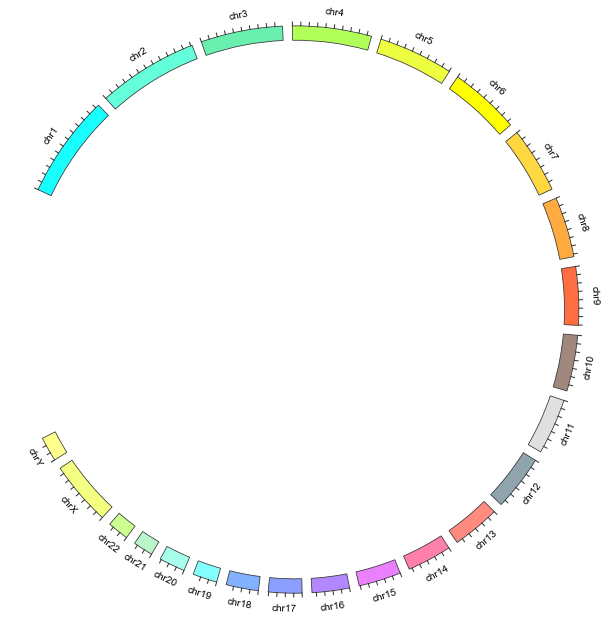

In [7]:
circle.figure

In [8]:
#cytoband
import collections
color_dict   = {"gneg":"#FFFFFF00", "gpos25":"#EEEEEE", "gpos50":"#BBBBBB", "gpos75":"#777777", "gpos100":"#000000", "gvar":"#FFFFFF00", "stalk":"#C01E27", 
               "acen":"#D82322"}

arcdata_dict = collections.defaultdict(dict)
with open("sample_data/example_data_chromosome_cytoband.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1 
        width = int(line[2])-(int(line[1])-1) 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["colors"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["colors"].append(color_dict[line[-1]])

for key in arcdata_dict:
    circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[935,985], facecolor=arcdata_dict[key]["colors"])    

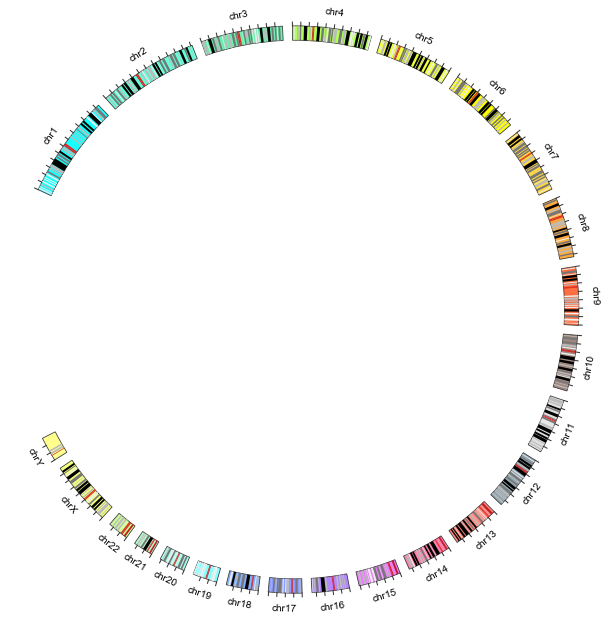

In [9]:
circle.figure

In [10]:
#scatter plot
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open("sample_data/example_data_point.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        mid   = (start+end)/2
        value = float(line[-1]) 
        values_all.append(value) 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["values"] = []
        arcdata_dict[name]["positions"].append(mid) 
        arcdata_dict[name]["values"].append(value)
    
vmin, vmax = min(values_all), max(values_all) 
for key in arcdata_dict:
    circle.scatterplot(key, data=arcdata_dict[key]["values"], positions=arcdata_dict[key]["positions"], 
                       rlim=[vmin-0.05*abs(vmin), vmax+0.05*abs(vmax)], raxis_range=(845,925), facecolor="orangered", spine=True) 

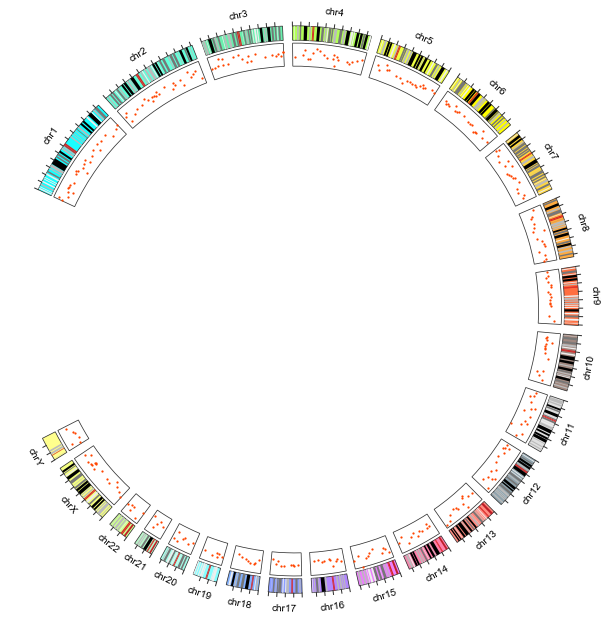

In [11]:
circle.figure

In [12]:
#line plot
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open("sample_data/example_data_point.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        mid   = (start+end)/2
        value = float(line[-1]) 
        values_all.append(value) 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["values"] = []
        arcdata_dict[name]["positions"].append(mid) 
        arcdata_dict[name]["values"].append(value)
    
vmin, vmax = min(values_all), max(values_all) 
for key in arcdata_dict:
    circle.lineplot(key, data=arcdata_dict[key]["values"], positions=arcdata_dict[key]["positions"], 
                    rlim=[vmin-0.05*abs(vmin), vmax+0.05*abs(vmax)], raxis_range=(755,835), linecolor="royalblue", spine=False) 

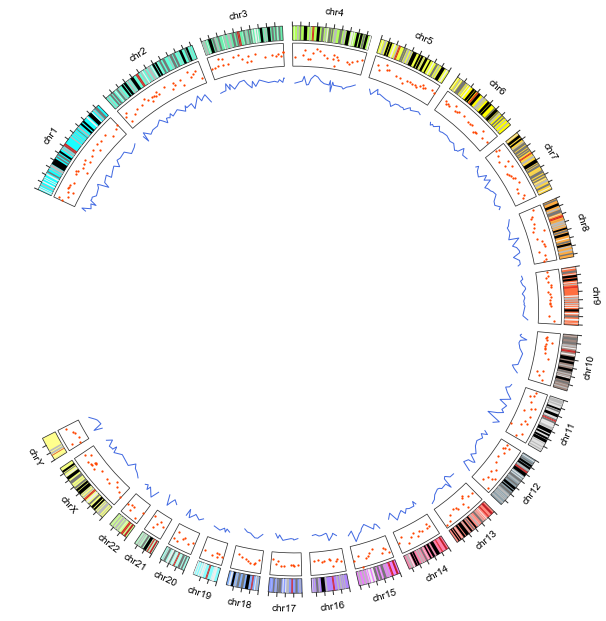

In [13]:
circle.figure

In [14]:
#bar plot
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open("sample_data/example_data_barplot.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        width = end-start 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["values"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["values"].append(float(line[-1]))
        values_all.append(float(line[-1]))

vmin, vmax = min(values_all), max(values_all) 
for key in arcdata_dict:  
    circle.barplot(key, data=arcdata_dict[key]["values"], positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], base_value=0.0, rlim=[vmin-0.05*abs(vmin), vmax+0.05*abs(vmax)],
                   raxis_range=[665,745], facecolor="y", spine=True)

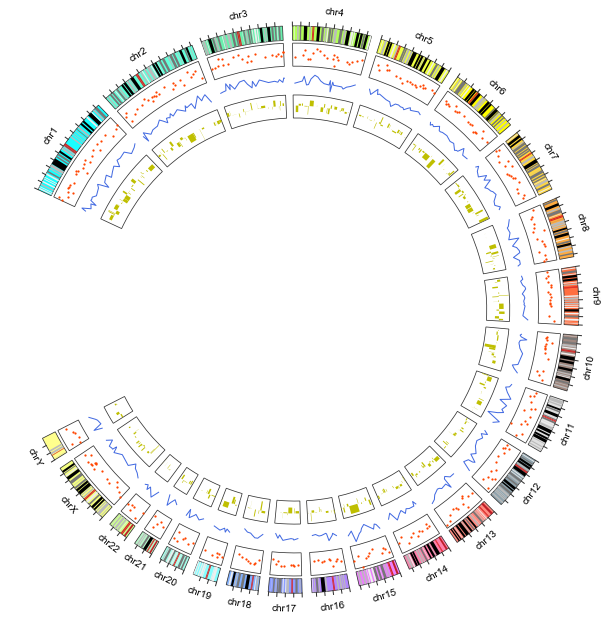

In [15]:
circle.figure

In [16]:
#heatmap
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open("sample_data/example_data_rect_gradual.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        width = end-start 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["values"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["values"].append(float(line[-1]))
        values_all.append(float(line[-1]))

vmin, vmax = min(values_all), max(values_all) 
for key in arcdata_dict:
    circle.heatmap(key, data=arcdata_dict[key]["values"], positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[615,655], vmin=vmin, vmax=vmax, 
                   cmap=plt.cm.viridis)

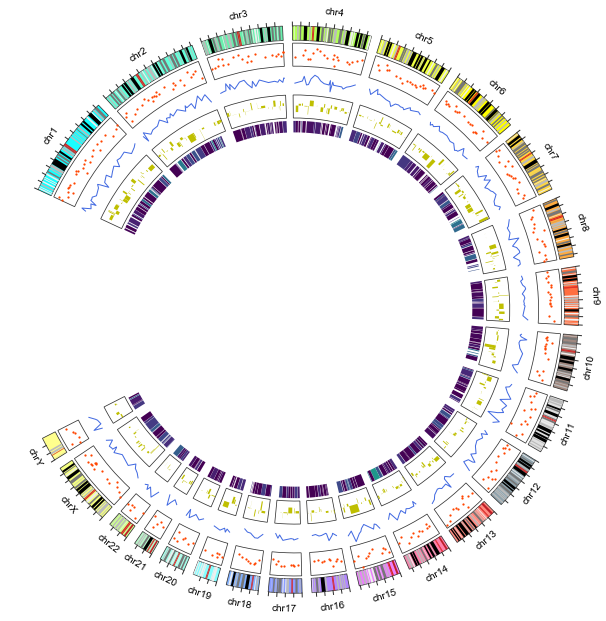

In [17]:
circle.figure

In [18]:
#linkplot
#heatmap
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
with open("sample_data/example_data_links.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name1  = line[0]     
        start1 = int(line[1])-1
        end1   = int(line[2])
        name2  = line[3]     
        start2 = int(line[4])-1
        end2   = int(line[5])
        source = (name1, start1, end1, 615)
        destination = (name2, start2, end2, 615)
        circle.chord_plot(source, destination, facecolor=circle.garc_dict[name1].facecolor)

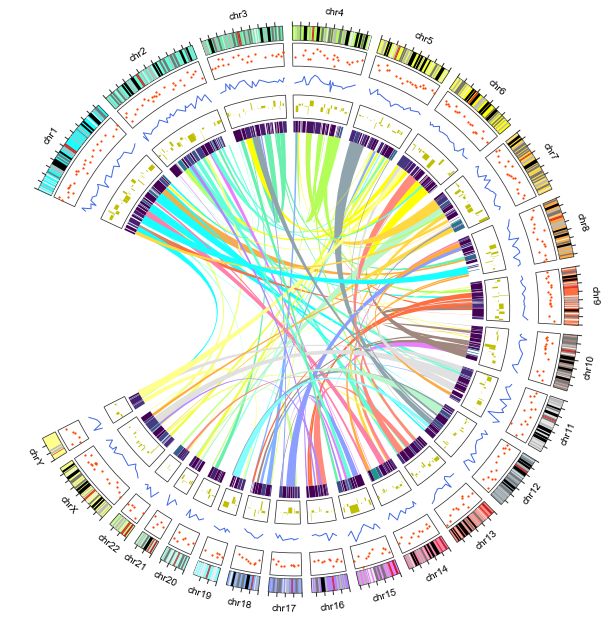

In [19]:
circle.figure

## Advanced plots

In [21]:
import matplotlib.pyplot as plt
from Bio import SeqIO 

In [22]:
record = SeqIO.read("sample_data/NC_000913.gbk", format="genbank")
garc   = Garc(arc_id="NC_000913", record=record, interspace=0, linewidth=0, 
              facecolor="#FFFFFF00", raxis_range=(0,10), 
              label="Escherichia coli str. K-12 substr. MG1655", label_visible=True)

In [23]:
record

SeqRecord(seq=Seq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC'), id='NC_000913.3', name='NC_000913', description='Escherichia coli str. K-12 substr. MG1655, complete genome', dbxrefs=['BioProject:PRJNA57779', 'BioSample:SAMN02604091'])

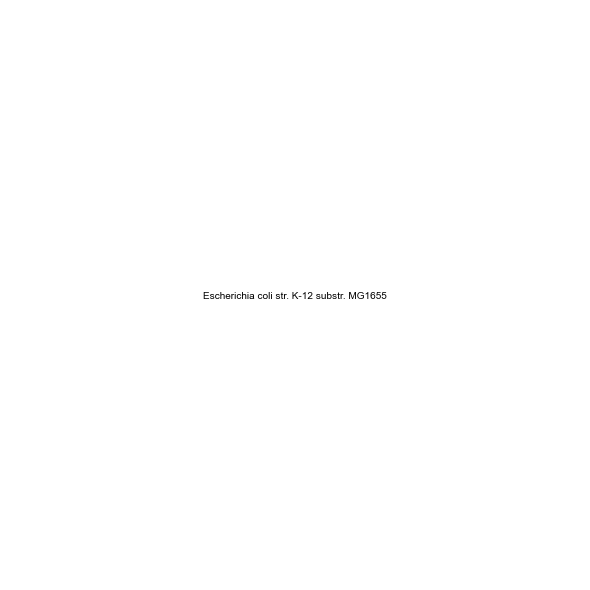

In [24]:
gcircle = Gcircle()
gcircle.add_garc(garc)
gcircle.set_garcs()

In [25]:
#Plot CDS
plus_CDS  = [] 
minus_CDS = [] 
for feat in garc.record.features:
    if feat.type == "CDS" and feat.strand >= 0:
        plus_CDS.append(feat)
    elif feat.strand == -1:
        minus_CDS.append(feat)
gcircle.featureplot("NC_000913", source=plus_CDS,  raxis_range=(700,780), facecolor="tomato")
gcircle.featureplot("NC_000913", source=minus_CDS, raxis_range=(780,860), facecolor="cornflowerblue")

In [26]:
#Plot GCskew
import copy
skews = garc.calc_nnskew(n1="G", n2="C")  
positive_skews=copy.deepcopy(skews)
positive_skews[skews<0]=0
negative_skews=copy.deepcopy(skews)
negative_skews[skews>=0]=0
gcircle.fillplot("NC_000913", positive_skews, rlim=(min(skews),max(skews)), base_value=0, raxis_range=(400,700), facecolor="r")
gcircle.fillplot("NC_000913", negative_skews, rlim=(min(skews),max(skews)), base_value=0, raxis_range=(400,700), facecolor="b")

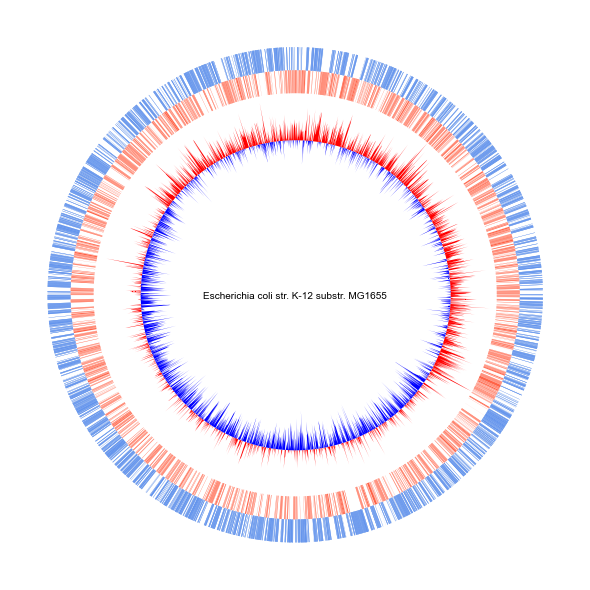

In [27]:
gcircle.figure

In [28]:
%pip install patchworklib

     ---------------------------------------- 40.2/40.2 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


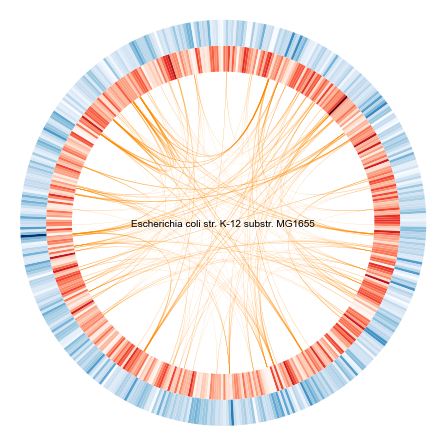

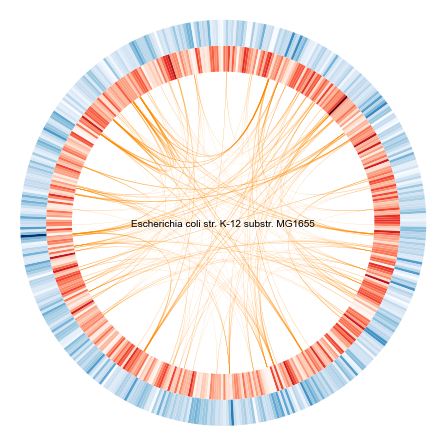

In [29]:
import patchworklib as pw 
record = SeqIO.read("sample_data/NC_000913.gbk", format="genbank")
garc   = Garc(arc_id="NC_000913.3", record=record, interspace=0, linewidth=0, 
              facecolor="#FFFFFF00", raxis_range=(0,10), 
              label="Escherichia coli str. K-12 substr. MG1655", label_visible=True)
gcircle = Gcircle(fig=pw.Brick._figure)
gcircle.add_garc(garc)
gcircle.set_garcs()


#calc CDS density
plus_CDS  = [] 
minus_CDS = [] 
for feat in garc.record.features:
    if feat.type == "CDS" and feat.strand >= 0:
        plus_CDS.append((feat.location.parts[0].start, feat.location.parts[-1].end))
    elif feat.strand == -1:
        minus_CDS.append((feat.location.parts[-1].start, feat.location.parts[0].end))
plus_density  = garc.calc_density(plus_CDS, window_size=10000)
minus_density = garc.calc_density(minus_CDS, window_size=10000)
gcircle.heatmap("NC_000913.3", plus_density,  raxis_range=(700,820), cmap=plt.cm.Reds)
gcircle.heatmap("NC_000913.3", minus_density, raxis_range=(820,940), cmap=plt.cm.Blues)

#cord plot
import collections
chord_dict = collections.defaultdict(list)
with open("sample_data/segdup.txt","r") as f:
    for line in f:
        line          = line.rstrip().split("\t")
        chord_dict[line[0]].append((line[1], int(line[2]), int(line[3]), 700)) 
        
for key in chord_dict:
    gcircle.chord_plot(chord_dict[key][0], chord_dict[key][1], facecolor="#ff8c0080")

circos2 = pw.cBrick(ax=gcircle.ax)
circos2.savefig()

## Protein interactions

In [2]:
%pip install nxviz -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
### The required libraries and packages ###
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm
import nxviz as nv

In [3]:
protein_list = ['TPH1','COMT','SLC18A2','HTR1B','HTR2C','HTR2A','MAOA',
            'TPH2','HTR1A','HTR7','SLC6A4','GABBR2','POMC','GNAI3',
            'NPY','ADCY1','PDYN','GRM2','GRM3','GABBR1']
proteins = '%0d'.join(protein_list)
url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=9606'
r = requests.get(url)

In [5]:
lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 
# dataframe with the preferred names of the two proteins and the score of the interaction
interactions = df[['preferredName_A', 'preferredName_B', 'score']]  

In [6]:
interactions.head()

,preferredName_A,preferredName_B,score
0,TPH1,GRM2,0.411
1,TPH1,GRM2,0.411
2,TPH1,POMC,0.439
3,TPH1,POMC,0.439
4,TPH1,NPY,0.458


In [25]:
G=nx.Graph(name='Protein Interaction Graph')
interactions = np.array(interactions) # convert to array for clarity
proteins = []
for i in range(len(interactions)):
    proteins.append(interactions[i][0])
    proteins.append(interactions[i][1])
proteins = list(set(proteins))

for s in proteins:
    G.add_node(s)

In [28]:
for n, d in G.nodes(data=True):
    G.nodes[n]["value"] = n

,value
GABBR2,GABBR2
HTR2C,HTR2C
GRM3,GRM3
GABBR1,GABBR1
MAOA,MAOA
GNAI3,GNAI3
NPY,NPY
POMC,POMC
HTR1B,HTR1B
SLC6A4,SLC6A4


In [33]:
for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    w = int(float(interaction[2])*100) # score as weighted edge

    
    # To include all the weighted connections, uncomment the following line
    # G.add_weighted_edges_from([(a,b,w)])
    
    # To only keep high scoring edges, use the following lines
    if w > 80: # only keep high scoring edges
        G.add_weighted_edges_from([(a,b,w)])

In [17]:
def text_alignment(x: float, y: float):
    """
    Align text labels based on the x- and y-axis coordinate values.
    This function is used for computing the appropriate alignment of the text
    label.
    For example, if the text is on the "right" side of the plot, we want it to
    be left-aligned. If the text is on the "top" side of the plot, we want it
    to be bottom-aligned.
    :param x, y: (`int` or `float`) x- and y-axis coordinate respectively.
    :returns: A 2-tuple of strings, the horizontal and vertical alignments
        respectively.
    """
    if x == 0:
        ha = "center"
    elif x > 0:
        ha = "left"
    else:
        ha = "right"
    if y == 0:
        va = "center"
    elif y > 0:
        va = "bottom"
    else:
        va = "top"

    return ha, va

def validate_fontdict(fontdict: Dict):
    """Validate `fontdict` keys."""
    valid_keys = {"family", "size", "stretch", "style", "variant", "weight"}
    assert set(fontdict) <= valid_keys

from functools import partial, update_wrapper
from typing import Dict, Hashable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Patch, Rectangle

from nxviz import encodings, layouts, utils
from nxviz.geometry import circos_radius, item_theta
from nxviz.polcart import to_cartesian, to_degrees

def circos_group(
    G: nx.Graph,
    group_by: Hashable,
    radius: float = None,
    radius_offset: float = 1,
    midpoint: bool = True,
    fontdict: Dict = {},
    ax=None,
):
    """Text annotation of node grouping variable on a circos plot."""
    validate_fontdict(fontdict)
    nt = utils.node_table(G)
    groups = nt.groupby(group_by).apply(lambda df: len(df)).sort_index()
    proportions = groups / groups.sum()
    starting_points = proportions.cumsum() - proportions
    if midpoint:
        starting_points += proportions / 2
    angles = starting_points * 360
    radians = angles.apply(lambda x: x / 360 * 2 * np.pi)

    if ax is None:
        ax = plt.gca()

    if radius is None:
        radius = circos_radius(len(G)) + radius_offset

    for label, theta in radians.to_dict().items():
        x, y = to_cartesian(radius, theta)
        ha, va = text_alignment(x, y)
        ax.annotate(label, xy=(x, y), ha=ha, va=va, **fontdict)

In [40]:
import nxviz.highlights as hl

In [49]:
a = 'HTR1A'
b = 'SLC6A4'

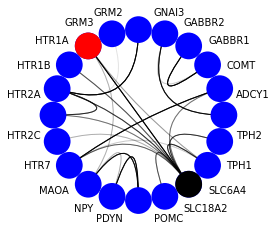

In [51]:
ax = nv.circos(G, group_by="value", edge_alpha_by="weight")
circos_group(G, group_by="value")
hl.circos_node(G, a, group_by="value")
hl.circos_node(G, b, group_by="value", color = "black")


In [55]:
def matrix_group(
    G: nx.Graph,
    group_by: Hashable,
    offset: float = -3,
    xrotation: float = 0,
    yrotation: float = 90,
    fontdict: Dict = {},
    ax=None,
):
    """Annotate matrix plot groups."""
    validate_fontdict(fontdict)
    if ax is None:
        ax = plt.gca()
    nt = utils.node_table(G)
    group_sizes = nt.groupby(group_by).apply(lambda df: len(df))
    proportions = group_sizes / group_sizes.sum()
    midpoint = proportions / 2
    starting_positions = proportions.cumsum() - proportions
    label_positions = (starting_positions + midpoint) * len(G) * 2
    label_positions += 1

    for label, position in label_positions.to_dict().items():
        # Plot the x-axis labels
        y = offset
        x = position
        ax.annotate(
            label,
            xy=(x, y),
            ha="center",
            va="center",
            rotation=xrotation,
            **fontdict,
        )

        # Plot the y-axis labels
        x = offset
        y = position
        ax.annotate(
            label, xy=(x, y), ha="center", va="center", rotation=yrotation, **fontdict
        )

In [56]:
def matrix_block(
    G: nx.Graph,
    group_by: Hashable,
    color_by: Hashable = None,
    alpha: float = 0.1,
    ax=None,
):
    """Annotate group blocks on a matrix plot.
    Most useful for highlighting the within- vs between-group edges.
    """
    nt = utils.node_table(G)
    group_sizes = nt.groupby(group_by).apply(lambda df: len(df)) * 2
    starting_positions = group_sizes.cumsum() + 1 - group_sizes

    colors = pd.Series(["black"] * len(group_sizes), index=group_sizes.index)
    if color_by:
        color_data = pd.Series(group_sizes.index, index=group_sizes.index)
        colors = encodings.data_color(color_data, color_data)
    # Generate patches first
    patches = []
    for label, position in starting_positions.to_dict().items():
        xy = (position, position)
        width = height = group_sizes[label]

        patch = Rectangle(
            xy, width, height, zorder=20, alpha=alpha, facecolor=colors[label]
        )
        patches.append(patch)

    if ax is None:
        ax = plt.gca()
    # Then add patches in.
    for patch in patches:
        ax.add_patch(patch)

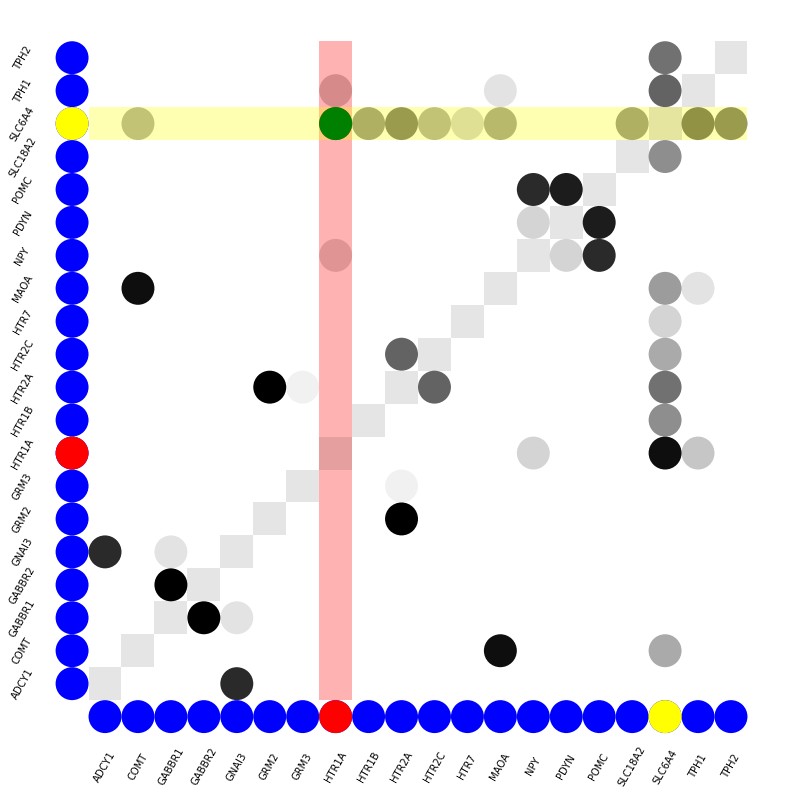

In [63]:
fig, ax = plt.subplots(figsize=(14, 14)) 
ax = nv.matrix(G, group_by="value", edge_alpha_by="weight")
matrix_group(G, group_by="value", xrotation=60, yrotation=60)
matrix_block(G, group_by="value", alpha=0.1)
hl.matrix_node(G, a, group_by="value")
hl.matrix_node(G, b, group_by="value", color="yellow")

hl.matrix_row(G, a, group_by="value")
hl.matrix_row(G, b, group_by="value", axis="y", color="yellow")

hl.matrix_edge(G, a, b, group_by="value", color ='green')